[View in Colaboratory](https://colab.research.google.com/github/edgarbanhesse/ia369y-affective-computing/blob/master/T2_Sentiment_Analysis.ipynb)

## T2 - Análise de Sentimentos em Textos

### Objetivo

O objetivo desta tarefa é expor os alunos aos desafios práticos envolvidos na análise de textos e na atribuição de valores de valência ou rótulos de emoções a sentenças.

Não é objetivo desta tarefa avaliar a acurácia de detecção ou a eficiência do modelo implementado mas a análise crítica do projeto e o amadurecimento em relação ao problema.

### Descrição da Tarefa

Esta tarefa deverá ser realizada individualmente ou em dupla.

Deve-se escolher um entre os dois problemas propostos abaixo.


### Problema escolhido #2

 - Este problema utilizará a mesma base de dados utilizada no SemEval 2007 - 4th International Workshop on Semantic Evaluations, Task 14, Affective Tests.
 - A base de treinamento conta com 250 manchetes em inglês de jornais e websites (Google, CNN, etc.)
 - A cada manchete está associado um score de (0 a 100)  para os rótulos "anger", "disgust", "fear", "joy", "sadness", "surprise"
 - Também será fornecida uma base de testes e os rótulos "golden" fornecidos durante a conferência.
 - Todos os dados podem ser acessados pelo link, abaixo. Mas atenção, considerar apenas os dados referentes  a rótulos de emoções (identificados com sufixo *emotions*). A leitura dos arquivos README é essencial para o entendimento da base. http://web.eecs.umich.edu/~mihalcea/affectivetext/
 - A tarefa consiste em definir a abordagem ao problema, o modelo de classificação, as regras de análise e deverá realizar uma implementação prática do algoritmo definido.

### Dupla

- Edgar Lopes Banhesse RA 993396
- Rodolfo De Nadai RA 208911

## Abordagem para resolução do problema

Para resolver o problema a abordagem será composta pelas seguintes etapas:

1) Pré-processamento do texto - consiste em preparar a base de treinamento que será utilizada para treinar o modelo de classificação.

2) Escolha e treinamento do classificador - Iremos avaliar vários classificadores de Regressão, para verificar qual deles possui melhor acurácia levando em consideração a pequena quantidade de dados.

3) Avaliar o modelo - utilizar métricas, tais como: precisão (precision), revocação (recall) e medida F (f1-score) para avaliar a acurácia dos resultados obtidos com o modelo.

4) Melhorar o modelo - treinar o modelo de classificação utilizando trigramas.

5) Avaliar o modelo novamente - repetir o passo 3.

6) Opotunidades - analisar os resultados obtidos em busca de oportunidades.
- Vocês concordam com os rótulos que o algoritmo atribuiu?
- Foi possível descobrir algo relevante sobre os dados a partir da análise de sentimentos?
- Considerando que nenhum modelo é perfeito, quais são os pontos fracos do algoritmo implementado?
- Quais seriam os pontos fortes?

7) Conclusão - finalizar o experimento relatando as principais descobertas.

8) Lições aprendidas - registrar as principais lições aprendidas durante a realização da tarefa.

## Iniciando a resolução do Problema

#### 1. Download do Dataset a ser utilizado e descompactação do mesmo.

In [3]:
!wget http://web.eecs.umich.edu/~mihalcea/downloads/AffectiveText.Semeval.2007.tar.gz
!tar -zxvf AffectiveText.Semeval.2007.tar.gz
!ls
!ls AffectiveText.trial

!pip install torch torchvision


Redirecting output to ‘wget-log’.
AffectiveText.test/
AffectiveText.test/affectivetext_test.xml
AffectiveText.test/README
AffectiveText.test/affectivetext_test.valence.gold
AffectiveText.test/affectivetext_test.emotions.gold
AffectiveText.trial/
AffectiveText.trial/affectivetext_trial.valence.gold
AffectiveText.trial/affectivetext_trial.emotions.gold
AffectiveText.trial/affectivetext_trial.xml
AffectiveText.trial/README
AffectiveText.Semeval.2007.tar.gz  AffectiveText.trial	wget-log
AffectiveText.test		   sample_data
affectivetext_trial.emotions.gold  affectivetext_trial.xml
affectivetext_trial.valence.gold   README
    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58b36000 @  0x7f6b02b961c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0

#### 2. Importação de bibliotecas.

In [35]:
import re
from collections import namedtuple
import nltk
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

%matplotlib inline

np.warnings.filterwarnings('ignore')

# Download de alguns dataset disponibilizados pelo NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('movie_reviews')
nltk.download('sentence_polarity')
nltk.download('sentiwordnet')
nltk.download('stopwords')
nltk.download('words')

from nltk.corpus import movie_reviews
# from nltk.corpus import sentence_polarity
# from nltk.corpus import sentiwordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

Conjunto = namedtuple('Conjunto', ['uid', 'phrase',
                                   'tokens',
                                   'valence', 'anger',
                                   'disgust', 'fear',
                                   'joy', 'sadness', 'surprise'])

def normalization(a, b, x):
    return a + (((x - np.min(x)) * (b-a)) / (np.max(x) - np.min(x)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package sentence_polarity to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package sentence_polarity is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


### 3. Importando o Dataset do SemEval 2007 para uma estrutura.

 - **Phrases**: id, phrase
 - **Emotions**: id, anger, disgust, fear, joy, sadness, surprise 
 - **Valence**: id, valence
 
Valor de retorno da função load_semeval_dataset:
 
 - **Content**: uid, phrase, valence,  anger, disgust, fear, joy, sadness, surprise

In [0]:
def clean_phrase(phrase):
    phrase = phrase.lower()
    # Remove pontuação
    phrase = re.sub(r'[\"\'!@#$%&*\(\)-_=+{}\[\]:;>.<,|\\`´]', '', phrase)
    # Remover stopwords em inglês e Lematização das palavras
    wordnet_lemmatizer = WordNetLemmatizer()
    # stwords = set(stopwords.words('english'))
    stwords = set(ENGLISH_STOP_WORDS)
    phrase = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in phrase.split() if word not in stwords and len(word) > 2])
    # Remove espaços em branco extras
    phrase = re.sub(r'\s{1,}', ' ', phrase)
    return phrase


def tokenize(phrase):
    # Limpar e retorna trigramas da frase
    return clean_phrase(phrase).split()


def load_semeval_dataset(fname='test'):
    content = []
    phrases = []
    emotions = []
    valences = []
    with open(f'AffectiveText.{fname}/affectivetext_{fname}.xml') as fxml:
        parser = BeautifulSoup(fxml.read())
        phrases = list(filter(None, parser.text.split('\n')))
    with open(f'AffectiveText.{fname}/affectivetext_{fname}.emotions.gold') as femotions:
        emons = list(filter(None, femotions.read().split('\n')))
        for emotion in emons:
            emon = [int(e) for e in emotion.split()]
            emotions.append(emon)
    with open(f'AffectiveText.{fname}/affectivetext_{fname}.valence.gold') as fvalences:
        valens = list(filter(None, fvalences.read().split('\n')))
        for valence in valens:
            valen = [int(v) for v in valence.split()]
            valences.append(valen)
    for i, phrase in enumerate(phrases):
        content.append(Conjunto(uid=valences[i][0],
                                phrase=phrase,
                                tokens=tokenize(phrase),
                                valence=valences[i][1:][0],
                                anger=emotions[i][1],
                                disgust=emotions[i][2],
                                fear=emotions[i][3],
                                joy=emotions[i][4],
                                sadness=emotions[i][5], 
                                surprise=emotions[i][6]))
    return content

# Carregar os dados de test e trial
train = load_semeval_dataset('test')
test = load_semeval_dataset('trial')
# train = load_semeval_dataset('trial')
# test = load_semeval_dataset('test')

### 4. TF-IDF

Implementação do método estatístico TF-IDF e comparativo com a versão implementada pela biblioteca scikit-learn.

Na biblioteca da scikit-learn é aplicada dentre outros procedimentos a normalização nos termos resultantes da tf-idf. A normalização utilizada é a distância euclidiana dos valores. É possível verificar uma explicação detalhada de alguns passos da implementação no [site](http://scikit-learn.org/stable/modules/feature_extraction.html) deles.

Nossa implementação abaixo, segue o padrão apresentado na [wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

Onde:

$tfidf(t, d, D) = tf(t,d) \times idf(t, D)$

$tf(t, d) = f_{t,d} / \Sigma{f_{t',d}}$

$idf(d, D) = \log \frac{|D|}{d}$

Sendo $t$ o termo (palavra), $d$ o documento e $D$ o conjunto de documentos.

In [0]:
class TfidfImpl:

    def __init__(self, stopwords=None):
        self.stopwords = stopwords
    
    def clean_phrase(self, phrase):
        phrase = phrase.lower()
        # Remove pontuação
        phrase = re.sub(r'[\"\'!@#$%&*\(\)-_=+{}\[\]:;>.<,|\\`´]', '', phrase)
        if self.stopwords == 'english':
            # Remover stopwords em inglês e Lematização das palavras
            wordnet_lemmatizer = WordNetLemmatizer()
            # stwords = set(stopwords.words('english'))
            stwords = set(ENGLISH_STOP_WORDS)
            phrase = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in phrase.split() if word not in stwords and len(word) > 2])
        # Remove espaços em branco extras
        phrase = re.sub(r'\s{1,}', ' ', phrase)
        return phrase


    def tokenize(self, phrase):
        # Limpar e retorna trigramas da frase
        return self.clean_phrase(phrase).split()
    
    def bag_of_words(self, phrases):
        bow = []
        for phrase in phrases:
            bow += phrase
        return sorted(set(bow))


    def compute_tf(self, words):
        tf = {}
        lbow = len(words)
        for word in words:
            tf[word] = tf.get(word, 0) + 1
        for word, count in tf.items():
            tf[word] = count / lbow
        return tf


    def compute_idf(self, phrases, N, bow):
        idfs = {}
        for df in bow:
            idfs[df] = idfs.get(df, 0)
            for words in phrases:
                if df in words:
                    idfs[df] = idfs.get(df, 0) + 1
        for df in idfs.keys():
            idfs[df] = np.log10(N / idfs[df])
        return idfs


    def compute(self, phrases):
        # Checagem... e conversão
        assert len(phrases) > 0
        if type(phrases[0]) is str:
            phrases = [self.tokenize(phrase) for phrase in phrases]
        
        tf_idf = {}
        N = len(phrases)
        bow = self.bag_of_words(phrases)
        idf = self.compute_idf(phrases, N, bow)
        for words in phrases:
            tf = self.compute_tf(words)
            for word, val in tf.items():
                tf_idf[word] = val * idf[word]
        return tf_idf

Resultados das funções criadas acima:

In [5]:
# Convertendo o conjunto montado acima para apenas as frases
# phrases = []
# conjuntos = test + trial
# for conj in conjuntos:
#    words = conj.tokens
#    phrases.append(' '.join(words))

# Testes  
phrases = ['The cat is in the hole', 'The rat is in the hole', 'The dog are looking at you througth the hole']

# Mostrando apenas as primeiras palavras com menor valor
head = 5

print('Nossa implementação: ')
Tfidf = TfidfImpl(stopwords='english')
tf_idf = Tfidf.compute(phrases)
df = pd.DataFrame({'term': list(tf_idf.keys()), 'weight': list(tf_idf.values())})
df = df.sort_values(by='weight', ascending=True)
display(df.head(head))

print()
print('-' * 20)
print('Implementação do Scikit-Learn: TfidfVectorizer')
vectorizer = TfidfVectorizer(stop_words='english', norm=None, smooth_idf=False)
transformed_weights = vectorizer.fit_transform(phrases)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=True)
display(weights_df.head(head))

print()
print('-' * 20)
print('Implementação do Scikit-Learn: CountVectorizer + TfidfTransformer')
cvec = CountVectorizer(stop_words='english')
cvec.fit(phrases)
cvec_counts = cvec.transform(phrases)
transformer = TfidfTransformer(norm=None, smooth_idf=False)
transformed_weights = transformer.fit_transform(cvec_counts)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=True)
display(weights_df.head(head))

Nossa implementação: 


,term,weight
1,hole,0.000000
3,dog,0.119280
4,looking,0.119280
5,througth,0.119280
0,cat,0.238561



--------------------
Implementação do Scikit-Learn: TfidfVectorizer


,term,weight
0,cat,0.699537
1,dog,0.699537
3,looking,0.699537
4,rat,0.699537
5,througth,0.699537



--------------------
Implementação do Scikit-Learn: CountVectorizer + TfidfTransformer


,term,weight
0,cat,0.699537
1,dog,0.699537
3,looking,0.699537
4,rat,0.699537
5,througth,0.699537


## Verificando valência dos dados

Como primeiro teste de validação, iremos testar modelos de ML e Deep Learning no eixo da valência dos dados **POSITIVO x NEGATIVO**.

### Preparar os dados

Antes de adicionar os dados para os modelos de ML (Machine Learning que iremos testar) é necessário prepará-los.

Conforme demonstrado acima, utilizaremos o TF-IDF como métrica estatística para converter os textos em vetores que possam ser processados pelos modelos.

Por questões apresentadas acima, iremos utilizar o cálculo do TF-IDF disponibilizado pela scikit-learn.

Quanto os dados estão esparsos:


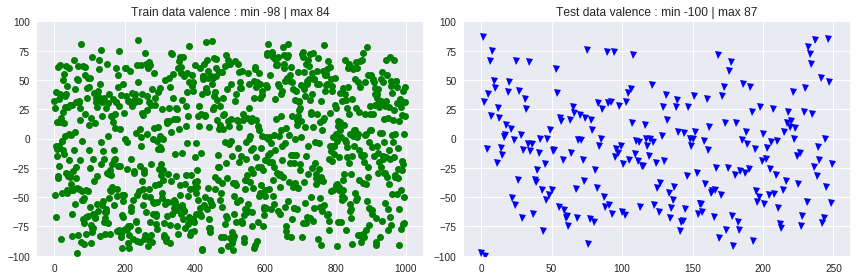

In [6]:
# Import dos modelos a serem testados
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge, BayesianRidge
# Importanto as funções matemáticas para as métricas.
# Como os modelos são de regressão, precisamos utilizar métodos como o MSE e R2
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict


def retorna_frases(conjunto):
    """Retorna o conjunto de dados a serem utilizados no modelos."""
    frases = [conj.phrase for conj in conjunto]
    valencia = [conj.valence for conj in conjunto]
    sentimentos = [[conj.anger, conj.disgust, conj.fear, conj.joy, conj.sadness, conj.surprise] for conj in conjunto]
    return frases, valencia, sentimentos

# Convertendo o conjunto montado acima para apenas as frases
train_frases, train_valencia, train_sent = retorna_frases(train)
test_frases, test_valencia, test_sent = retorna_frases(test)

# Definimos aqui, algumas frases sem label para avaliarmos o modelo
predict_frases = [
    'Bad news comes first, good news after',
    'I enjoy too much this movie, i love it',
    'Hate you, and your brother',
    'Great day to walk in the park and play with my dog',
    'Don\'t you worry my friend',
    'I have bad news for you sir',
    'I\'m suffering from an illness',
    'It hurts so much',
    'I dislike movies that have people walking in the park',
    'Excellent job, you are such a great employee',
    'Mohamed step into the dark mist... and discover marvelous things',
    'This smartphone sucks big time... what a shit piece of tech',
]

# Conjunto completo de frases e seus valores
datasets = np.array(train_frases + test_frases)
values = np.array(train_valencia + test_valencia)

# Criando o TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
transformed_weights = vectorizer.fit_transform(datasets)

X_train, X_test, y_train, y_test  = train_test_split(
        transformed_weights, 
        values,
        train_size=0.92, 
        random_state=1179)

# Recuperando os pesos para cada um dos itens a serem avaliados
validate_transformed_weights = vectorizer.transform(predict_frases).toarray()

print('Quanto os dados estão esparsos:')
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title(f'Train data valence : min {np.min(train_valencia)} | max {np.max(train_valencia)}')
plt.plot(np.array(range(0, len(train_valencia))), train_valencia, 'go')
plt.ylim([-100, 100])
plt.subplot(122)
plt.title(f'Test data valence : min {np.min(test_valencia)} | max {np.max(test_valencia)}')
plt.plot(np.array(range(0, len(test_valencia))), test_valencia, 'bv')
plt.ylim([-100, 100])
plt.tight_layout()
plt.show()

### Testando os modelos de ML

Estamos verificando os modelos de ML para validar qual o melhor modelo se encaixa no problema que estamos tentando avaliar.

Pelo problema ser de Regressão e não de Classificação (não queremos saber as classes dos itens, mas o quanto ele se aproxima de seus conjuntos pares).

Faremos abaixo e teste da implementação mais simples de um algoritmo de Machine Learning, a Regressão Linear de uma variável e Regressão Linear Multipla.

#### Simple Linear Regression

Para calcular a Regeressão Linear mais simples (de uma variável), utilizamos o seguinte cálculo:

$Y = \alpha + \beta x$

No caso precisamos encontrar os valores de $\alpha$ e $\beta$, para isso utilizaremos a equação:

$\alpha = \hat{y} - \beta \hat{x} $

$\beta = Cov(x, y) / Var(x)$

$Cov(x, y) = \Sigma_{i=0}^N \frac{(x - \hat{x}) (y - \hat{y})}{N}$

Onde $\hat{x}$ e $\hat{y}$ são respectivamente as médias de x e y, Cov é a covariancia entre x e y, e Var é a variância.

Referências: 
 - [Simple Linear Regression](https://en.wikipedia.org/wiki/Simple_linear_regression)
 - [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares)

Equal implementation (scipy):  True
Equal implementation (scikit-learn):  True


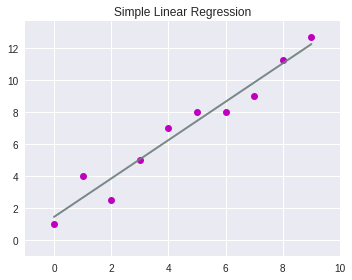

In [7]:
# Regressão Linear de uma variável

x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) 
y = np.array([1, 4, 2.5, 5, 7, 8, 8, 9, 11.25, 12.67])


def linear_regression(x, y):
    # covariance
    N = len(x)
    c_xy = np.sum(((x - np.mean(x)) * (y - np.mean(y))) / N)
    b = c_xy / np.var(x)
    a = np.mean(y) - (b * np.mean(x))
    return a + (b * x)

e = linear_regression(x, y)
# scipy implementation
e_sc = sc.stats.linregress(x, y)
e_sc_value = e_sc.slope * x + e_sc.intercept
# Scikit-Learn implementation
k = [[m] for m in x]
reg = LinearRegression().fit(k, y)
e_sk_value = reg.coef_ * k + reg.intercept_

# show off
error = 1e-10
print('Equal implementation (scipy): ', np.sum(e - e_sc_value) < error)
print('Equal implementation (scikit-learn): ', np.sum(e - e_sk_value) < error)

plt.figure(figsize=(5, 4))
plt.title('Simple Linear Regression')
plt.plot(x, y, 'mo')
plt.plot(e, alpha=.75)
plt.plot(e_sc_value, alpha=.5)
plt.plot(e_sk_value, alpha=.25)
plt.xlim([-1, np.max(x) + 1])
plt.ylim([-1, np.max(y) + 1])
plt.tight_layout()
plt.show()

#### Regressão Linear de Múltiplas Variáveis

Para calcular a Regressão Linear de Múltiplas Variáveis, podemos utilizar a notação matricial de acordo com as fórmulas abaixo:

$Y = x\beta$

$\beta = (x^Tx)^{-1}x^Ty$

Esta implementação funciona bem para vetores com poucas dimensões, ou que tenha uma lineariedade explicita.

In [69]:
x = np.array([
    [0, 5, 7, 9, 10],
    [2.27, 3.27, 8.27, 10, 12],
    [0.5, 6.5, 7.5, 9, 11],
    [4.5, 9.5, 15.5, 17, 17.5],
]) 
y = np.array([2.5, 9, 11.25, 13.45])

def linear_regression_mul(x, y):
    x = np.array(x)
    # b is least squares calculation
    # line bellow only works for smaller matrices
    # m,n = x.shape
    # noise = .000001 * np.random.rand(m, n)
    # x = x + noise
    # T = x.T
    # b = np.dot(np.linalg.inv(np.dot(T, x)), np.dot(T, y))
    b = np.linalg.lstsq(x, y)[0]
    return b, np.dot(x, b)

coef, y_pred = linear_regression_mul(x, y)

reg = LinearRegression(fit_intercept=False).fit(x, y)
coef_sk, y_pred_sk = reg.coef_, reg.predict(x)

print('-' * 20)
print('Coefficients')
print('Implementation: ', coef)
print('Scikit-Learn  : ', coef_sk)

print('-' * 20)
print('Predictions')
print('Implementation: ', y_pred)
print('Scikit-Learn  : ', y_pred_sk)

--------------------
Coefficients
Implementation:  [ 3.79700657  2.32827072 -1.28614088 -4.4622198   4.00216107]
Scikit-Learn  :  [ 3.79700657  2.32827072 -1.28614088 -4.4622198   4.00216107]
--------------------
Predictions
Implementation:  [ 2.5   9.   11.25 13.45]
Scikit-Learn  :  [ 2.5   9.   11.25 13.45]


Comparativo da função criada acima, com a do Scikit-Learn, usando os dados verdadeiros que foram importados e serão validados mais a frente por diversos modelos.

In [71]:
coef, y_pred = linear_regression_mul(X_train.toarray(), y_train)

md = LinearRegression().fit(X_train.toarray(), y_train)
coef_sk, y_pred_sk = md.coef_, md.predict(X_train.toarray())

print('-' * 20)
print('Coefficients')
print('Implementation: ', coef)
print('Scikit-Learn  : ', coef_sk)

print('-' * 20)
print('Predictions')
print('Implementation: ', np.floor(y_pred[:10]))
print('Scikit-Learn  : ', np.floor(y_pred_sk[:10]))

--------------------
Coefficients
Implementation:  [-1.52935096e+14 -1.63605209e+14  3.98704977e+15 ...  5.48164201e+13
  5.48164201e+13  5.48164201e+13]
Scikit-Learn  :  [-2.02712252e+14 -4.72802372e+13  1.95651407e+14 ... -1.22924602e+13
 -1.22924602e+13  4.82840417e+12]
--------------------
Predictions
Implementation:  [-77.  79. -37.   4.   1. -52.  49.  47.  52.   9.]
Scikit-Learn  :  [-76.  84. -30.   4.  -4. -63.  53.  51.  39.  10.]


Para facilitar o trabalho no desenvolvimento e validação de diversos algoritmos de Machine Learning iremos continuar utilizando os modelos implementados na biblioteca scikit-learn, como Regressão Linear, Perceptron entre outros.

 - **LinearRegression**
 - **Perceptron**
 - **KNeighborsRegressor**
 - **BayesianRidge**
 - **LinearSVC**
 - **Ridge**
 
Como métrica de resultado, vamos utilizar  **Root Mean Squared Error** and **Coefficient of Determination(R2 Score)** duas métricas amplamente utilizada em Machine Learning para nos dizer se nosso modelo esta se comportando corretamente.

O melhor valor para RMSE é de 0.0, para o R2 seria em torno de 1.0 (valores menores que zero podem representar falhas no modelo).

In [322]:
models = [
    LinearRegression(),
    Perceptron(max_iter=15),
    KNeighborsRegressor(),   
    BayesianRidge(),
    LinearSVC(),
    Ridge(),
]

# Vamos rodar para cada um dos modelos o fit dos dados e apresentar os resultados
for modelo in models:
    X_train_weights = X_train.copy()
    X_test_weights = X_test.copy()
    if isinstance(modelo, Perceptron) or isinstance(modelo, BayesianRidge):
        X_train_weights = X_train_weights.toarray()
        X_test_weights = X_test_weights.toarray()
    modelo.fit(X_train_weights, y_train)
    predirect_train = modelo.predict(X_train_weights)
    predirect_test = modelo.predict(X_test_weights)
    print('-' * 20)
    print(f'Model: {modelo.__class__.__name__}')
    print('Score on train data: %s' % (round(modelo.score(X_train_weights, y_train) * 100, 2)))
    print('Score on test data: %s' % (round(modelo.score(X_test_weights, y_test) * 100, 2)))
    print('MSE train:   ', round(mean_squared_error(y_train, predirect_train), 2))
    print('R2  train:   ', round(r2_score(y_train, predirect_train), 2))
    print('MSE test:   ', round(mean_squared_error(y_test, predirect_test), 2))
    print('R2  test:   ', round(r2_score(y_test, predirect_test), 2))
    print('Predicted accuracy in each phrase:')
    # Predição para as frases
    accuracies = np.floor(modelo.predict(validate_transformed_weights))
    for i, phrase in enumerate(predict_frases):
        print(f'  - {phrase} : {accuracies[i]}')

--------------------
Model: LinearRegression
Score on train data: 99.95
Score on test data: 26.62
MSE train (best 0.0):    1.11
R2  train (best 1.0):    1.0
MSE test  (best 0.0):    1560.11
R2  test  (best 1.0):    0.27
Predicted accuracy in each phrase:
  - Bad news comes first, good news after : 13.0
  - I enjoy too much this movie, i love it : 21.0
  - Hate you, and your brother : -8.0
  - Great day to walk in the park and play with my dog : -11.0
  - Don't you worry my friend : 1.0
  - I have bad news for you sir : -3.0
  - I'm suffering from an illness : -8.0
  - It hurts so much : -8.0
  - I dislike movies that have people walking in the park : -12.0
  - Excellent job, you are such a great employee : 29.0
  - Mohamed step into the dark mist... and discover marvelous things : -1.0
  - This smartphone sucks big time... what a shit piece of tech : 38.0
--------------------
Model: Perceptron
Score on train data: 97.83
Score on test data: 1.0
MSE train (best 0.0):    2.81
R2  train (b

Vericando os dados e os modelos usando o método de **Cross Validation**.

*"... is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice."* https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In [47]:
# Cross folding value
cv = 10

# Conjunto completo de frases e seus valores
datasets_cross = np.array(train_frases + test_frases)
values_cross = np.array(train_valencia + test_valencia)

# TF-IDF do conjunto
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
crossval_transformed_weights = vectorizer.fit_transform(datasets_cross)

# Executando para cada modelo definido
for modelo in models:
    weights = crossval_transformed_weights.copy()
    if isinstance(modelo, Perceptron) or isinstance(modelo, BayesianRidge):
        weights = crossval_transformed_weights.toarray()
    # Predição e arredondamento dos valores encontrados.
    predicted_cross = np.floor(cross_val_predict(modelo, weights, values_cross, cv=cv)).astype(np.int64)
    print('-' * 20)
    print(f'Model: {modelo.__class__.__name__}')
    print('Real values:      ', values_cross[:13])
    print('Predicted values: ', predicted_cross[:13])
    print('MSE :   ', round(mean_squared_error(values_cross, predicted_cross), 2))
    print('R2  :   ', round(r2_score(values_cross, predicted_cross), 2))

--------------------
Model: LinearRegression
Real values:       [ 32 -48  26  40  -6 -67  14  -9 -15 -32 -34  61  -6]
Predicted values:  [ -2 -35  -8  -2 -25 -30  -9 -19  10  -8 -10  -9  -9]
MSE (best 0.0):    1637.18
R2  (best 1.0):    0.28
--------------------
Model: Perceptron
Real values:       [ 32 -48  26  40  -6 -67  14  -9 -15 -32 -34  61  -6]
Predicted values:  [ 28 -81 -98  73 -75 -62 -53   7  -4 -98  18 -18 -40]
MSE (best 0.0):    3269.92
R2  (best 1.0):    -0.44
--------------------
Model: KNeighborsRegressor
Real values:       [ 32 -48  26  40  -6 -67  14  -9 -15 -32 -34  61  -6]
Predicted values:  [ 15 -61 -21  13 -29 -25 -23  -2  20   0   0 -10  -5]
MSE (best 0.0):    1832.89
R2  (best 1.0):    0.19
--------------------
Model: BayesianRidge
Real values:       [ 32 -48  26  40  -6 -67  14  -9 -15 -32 -34  61  -6]
Predicted values:  [ -2 -34  -6  -1 -24 -28  -8 -18  10  -6  -9  -7  -8]
MSE (best 0.0):    1633.93
R2  (best 1.0):    0.28
--------------------
Model: LinearSVC

### Testando os modelo de Deep Learning

Vamos avaliar também um modelo básico de Deep Learning.

Estamos utilizando a biblioteca pytorch (outra lib de Deep Learning em python) para criação, treino e validação.

Optamos por ela, pela maior expressividade no desenvolvimento. 

Model Layers:
 - Linear -> ReLU
 - Linear -> ReLU
 - Linear
 - Linear -> ReLU
 - Linear


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_default_dtype(torch.float64)

def train_and_validate(x, y, z, predict_frases, loss_fn=None, optimizer='RMSprop', scheduler=True, epochs=200, learning_rate=1e-4): 
    # Work on gpu
    device = torch.device('cuda')
    
    # input | output dimensions
    D_in, D_out = x.shape[1], 1
    
    # Create model
    model = torch.nn.Sequential(
            torch.nn.Linear(D_in, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, D_out),
        ).to(device)
    if not loss_fn:
        loss_fn = torch.nn.MSELoss(size_average=False)
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'Adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=.5)
    if scheduler:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    
    print(f'Model: {model.__class__.__name__}')
    print(f'Loss Function: {loss_fn.__class__.__name__}')
    print(f'Optimizer: {optimizer.__class__.__name__}')
    if scheduler:
        print(f'Scheduler: {scheduler.__class__.__name__}')
    
    # Training the model
    loss_arr = np.zeros(epochs)
    for t in range(epochs):
        if scheduler:
            scheduler.step()
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)
        # Compute and print loss
        loss = loss_fn(y_pred, y)
        # Holding loss value to pretty print
        loss_arr[t] = loss.item()
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    predicted = model.forward(z).data.cpu().numpy()
    
    # Print predicted values
    for i, phrase in enumerate(predict_frases):
        val = np.floor(predicted[i][0]).astype(np.int64)
        print(f'  - {phrase} : {val}')
        
    # Ploting the model loss
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.title('Model loss')
    plt.plot(loss_arr)
    plt.subplot(122)
    plt.title('Data result')
    plt.plot(np.arange(0, 50), y[:50].cpu().numpy(), 'bv', label='from data')
    plt.ylim([-100, 100])
    plt.plot(np.array(range(0, len(predicted))), predicted, 'go', label='prediction')
    plt.ylim([-100, 100])
    plt.legend()
    plt.show()

Para usar o pytorch com melhor performance, vamos transformar os numpy arrays em torch tensors e enviá-los para serem processados na GPU do computador.

In [0]:
# Conjunto completo valores das frases
values = [[val] for val in np.array(train_valencia + test_valencia)]

# Work on gpu
device = torch.device('cuda')

# input | output | predict
x = torch.tensor(transformed_weights.toarray(), dtype=torch.float64, device=device)
y = torch.tensor(values, dtype=torch.float64, device=device)
z = torch.tensor(vectorizer.transform(predict_frases).toarray(), dtype=torch.float64, device=device)

# EPOCHS!! CHANGE TO RUN THE MODEL FIT MORE TIMES!
epochs = 75

Vamos iniciar o treinamento e avaliação de cada um dos testes de nossa simples rede neural.

Segue os resultados, onde apresentamos loss function, optimizer usado e as valências calculadas pelo modelo.

Model: Sequential
Loss Function: MSELoss
Optimizer: RMSprop
Scheduler: StepLR
  - Bad news comes first, good news after : 35
  - I enjoy too much this movie, i love it : 31
  - Hate you, and your brother : -11
  - Great day to walk in the park and play with my dog : -13
  - Don't you worry my friend : 6
  - I have bad news for you sir : 17
  - I'm suffering from an illness : -11
  - It hurts so much : -11
  - I dislike movies that have people walking in the park : -13
  - Excellent job, you are such a great employee : 35
  - Mohamed step into the dark mist... and discover marvelous things : 5
  - This smartphone sucks big time... what a shit piece of tech : 37


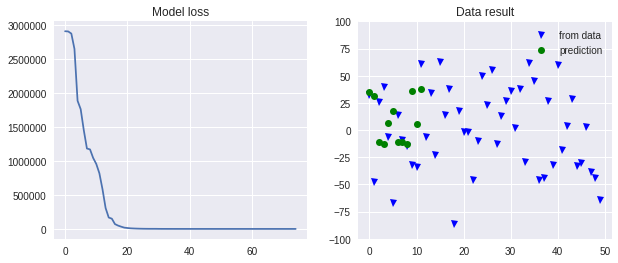

In [175]:
train_and_validate(x, y, z, predict_frases, epochs=epochs)

Model: Sequential
Loss Function: MSELoss
Optimizer: Adam
Scheduler: StepLR
  - Bad news comes first, good news after : 24
  - I enjoy too much this movie, i love it : 20
  - Hate you, and your brother : -9
  - Great day to walk in the park and play with my dog : -17
  - Don't you worry my friend : 3
  - I have bad news for you sir : 7
  - I'm suffering from an illness : -9
  - It hurts so much : -9
  - I dislike movies that have people walking in the park : -14
  - Excellent job, you are such a great employee : 23
  - Mohamed step into the dark mist... and discover marvelous things : 9
  - This smartphone sucks big time... what a shit piece of tech : 29


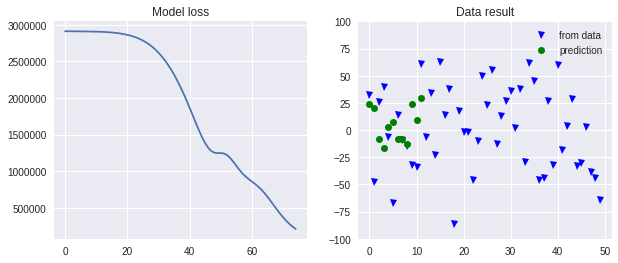

In [176]:
train_and_validate(x, y, z, predict_frases, optimizer='Adam', epochs=epochs)

Model: Sequential
Loss Function: MSELoss
Optimizer: RMSprop
Scheduler: StepLR
  - Bad news comes first, good news after : 34
  - I enjoy too much this movie, i love it : 30
  - Hate you, and your brother : -12
  - Great day to walk in the park and play with my dog : -13
  - Don't you worry my friend : 7
  - I have bad news for you sir : 19
  - I'm suffering from an illness : -12
  - It hurts so much : -12
  - I dislike movies that have people walking in the park : -13
  - Excellent job, you are such a great employee : 35
  - Mohamed step into the dark mist... and discover marvelous things : 6
  - This smartphone sucks big time... what a shit piece of tech : 37


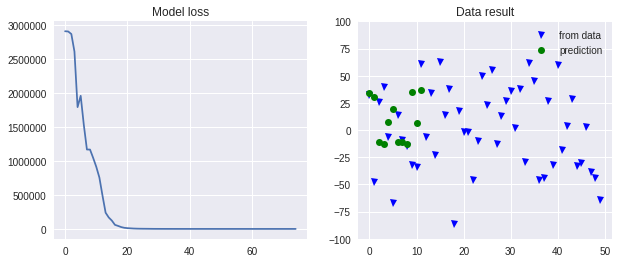

In [177]:
train_and_validate(x, y, z, predict_frases, optimizer='Adadelta', epochs=epochs)

Model: Sequential
Loss Function: L1Loss
Optimizer: RMSprop
Scheduler: StepLR
  - Bad news comes first, good news after : 29
  - I enjoy too much this movie, i love it : 23
  - Hate you, and your brother : -13
  - Great day to walk in the park and play with my dog : -11
  - Don't you worry my friend : 9
  - I have bad news for you sir : 5
  - I'm suffering from an illness : -13
  - It hurts so much : -13
  - I dislike movies that have people walking in the park : -10
  - Excellent job, you are such a great employee : 32
  - Mohamed step into the dark mist... and discover marvelous things : -5
  - This smartphone sucks big time... what a shit piece of tech : 30


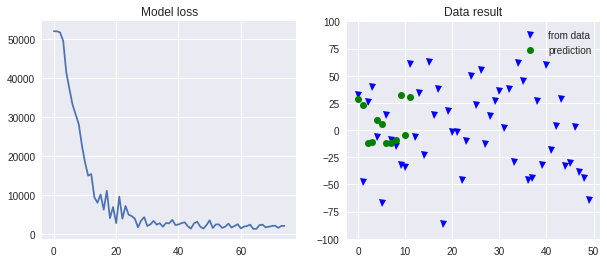

In [178]:
loss_fn = torch.nn.L1Loss(size_average=False)
train_and_validate(x, y, z, predict_frases, loss_fn=loss_fn, epochs=epochs)

## Analisando dados usando sentimentos

Em outro aspecto dos dados existentes no dataset do SemEval, é definido também valores de acordo com as emoções de cada frase.

Desse modo, iremos analisar usando os modelos acima, apresentados, estes dados mas apontando para os sentimentos descritos.

Conforme mencionado: **anger, disgust, fear, joy, sadness, surprise**